In [1]:
from functools import partial

In [2]:
def multiple(a, b):
    return a * b

double = partial(multiple, b=2)

double(4)

8

### generate data

In [3]:
import torch
from torch import tensor
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

In [4]:
n_clusters=6
n_samples =250

In [5]:
centroids = torch.rand(n_clusters, 2) * 70 - 35

In [6]:
for m in centroids:
    print(m)

tensor([-13.2330, -34.9103])
tensor([  5.4281, -32.1733])
tensor([21.5216,  2.5011])
tensor([27.2159, 20.2651])
tensor([-11.9420,  -6.8387])
tensor([-16.3534,  32.8694])


In [7]:
mu = centroids[0]
cov_matrix = torch.diag(tensor([5.,5.]))

distribution = MultivariateNormal(centroids[0], cov_matrix)
samples = distribution.sample(tensor([n_samples]))

In [8]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample(tensor([n_samples]))
samples = sample(centroids[0])

In [9]:
samples.shape

torch.Size([250, 2])

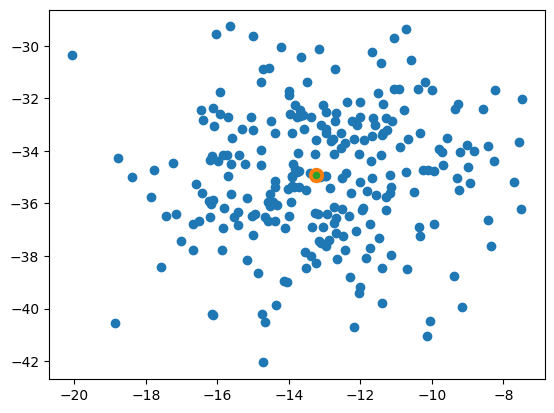

In [10]:
plt.scatter(samples[:,0], samples[:,1])
plt.scatter(mu[0], mu[1], marker='o', s=100)
plt.scatter(mu[0], mu[1], marker='o', s=20)

plt.show()

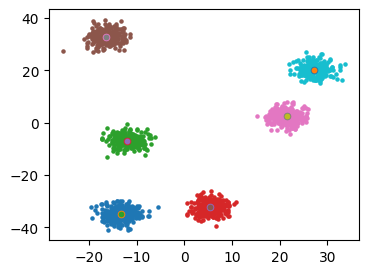

In [11]:
def plot_data(mu, samples):
    plt.scatter(samples[:,0], samples[:,1], s=5)
    plt.scatter(mu[0], mu[1], marker='o', s=20)
    plt.scatter(mu[0], mu[1], marker='o', s=10)
samples = []
plt.figure(figsize=(4, 3))
for i, mu in enumerate(centroids):
    mu_samples = sample(mu)
    samples.append(mu_samples)
    plot_data(mu, mu_samples)
plt.show()

In [12]:
samples = torch.concat(samples)

In [13]:
import math
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [14]:
from functools import partial

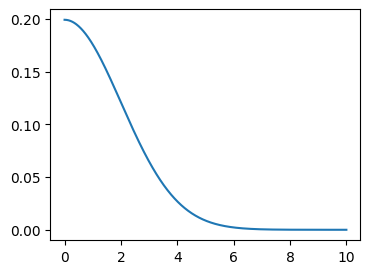

In [15]:
def plot_func(f):
    x = torch.linspace(0, 10, 1000)
    y = f(x)
    plt.figure(figsize=(4, 3))
    plt.plot(x, y)
    plt.show()
    
plot_func(partial(gaussian, bw=2))

### mean shift

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

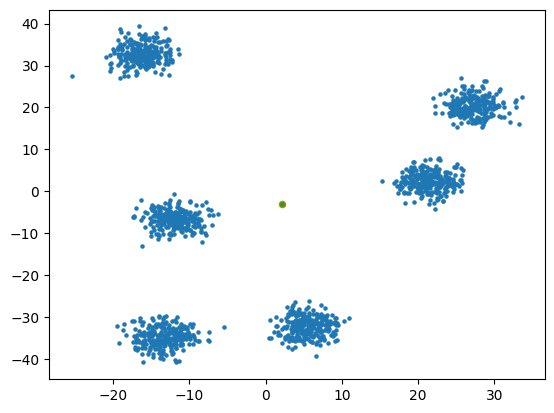

In [16]:
X = samples.clone()
plot_data(X.mean(0), X)

In [17]:
n, _ = samples.shape
d = torch.zeros((n, n))
for i, x in enumerate(X):
    d[i] = ((X - x) * (X - x)).sum(1).sqrt()
weight = gaussian(d, 2.5)

In [18]:
d

tensor([[ 0.0000,  4.6810,  4.9736,  ..., 62.0508, 64.5518, 62.9019],
        [ 4.6810,  0.0000,  4.7485,  ..., 65.3835, 67.7859, 66.1798],
        [ 4.9736,  4.7485,  0.0000,  ..., 66.9113, 69.4399, 67.7785],
        ...,
        [62.0508, 65.3835, 66.9113,  ...,  0.0000,  3.1140,  1.3410],
        [64.5518, 67.7859, 69.4399,  ...,  3.1140,  0.0000,  1.8385],
        [62.9019, 66.1798, 67.7785,  ...,  1.3410,  1.8385,  0.0000]])

In [19]:
weight[0:3, 0:3]

tensor([[0.1596, 0.0276, 0.0221],
        [0.0276, 0.1596, 0.0263],
        [0.0221, 0.0263, 0.1596]])

In [20]:
weight.shape

torch.Size([1500, 1500])

In [21]:
weight.sum(0).shape

torch.Size([1500])

In [22]:
weight = weight / weight.sum(0).reshape(-1, 1)

In [23]:
weight.shape

torch.Size([1500, 1500])

In [24]:
X.shape

torch.Size([1500, 2])

In [25]:
new_X = weight@X

In [26]:
def step(X):
    d = torch.zeros((n, n))
    for i, x in enumerate(X):
        d[i] = ((X - x) * (X - x)).sum(1).sqrt()
    weight = gaussian(d, 2.5)
    weight = weight / weight.sum(0).reshape(-1, 1)
    result = weight@X
    return result

new_X2 = step(X)

In [27]:
torch.allclose(new_X2, new_X)

True

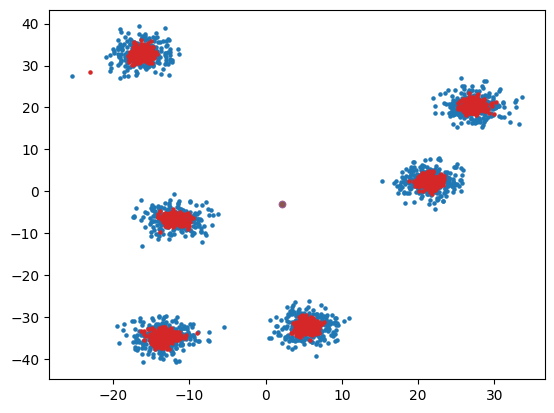

In [28]:
plot_data(X.mean(0), X)
plot_data(new_X.mean(0), new_X)

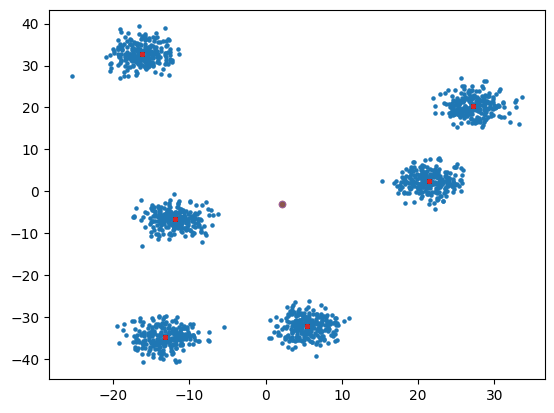

In [29]:
for i in range(10): new_X = step(new_X)
plot_data(X.mean(0), X)
plot_data(new_X.mean(0), new_X)

### implement k-means clustering

The algorithm takes two inputs - k (the number of clusters) and the dataset to be clustered. The algorithm works as follows:

* Randomly initialize k cluster centroids.

* Assign each data point to the closest cluster centroid (based on Euclidean distance).

* Recalculate the location of each cluster centroid as the average of all the data points assigned to it.

Repeat steps 2 and 3 until convergence (i.e., the cluster assignments no longer change or a maximum number of iterations is reached).

In [30]:
torch.manual_seed(1)
k = 3
centroids = torch.rand(k,2) * 70 - 30

In [31]:
centroids

tensor([[ 23.0342, -10.4482],
        [ -1.7852,  21.4279],
        [-27.9503,  25.9901]])

<function matplotlib.pyplot.show(close=None, block=None)>

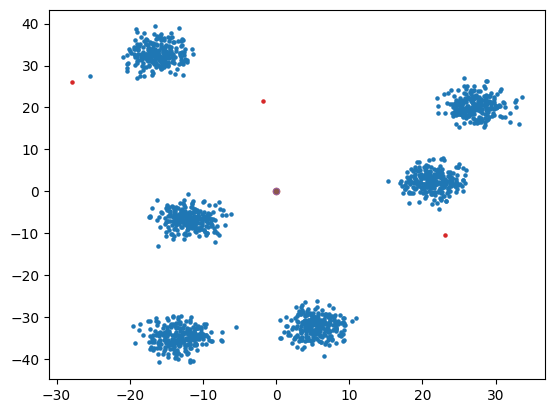

In [32]:
plot_data([0,0], X)
plot_data([0,0], centroids)
plt.show

In [33]:
def step(centroids):
    new_centroids = centroids.clone()

    d = torch.zeros((k, n))
    for i, x in enumerate(new_centroids):
        d[i] = ((X - x) * (X - x)).sum(1).sqrt()

    indices = d.min(0).indices

    for i in range(k):
        print(i, len(X[indices==i]))
        if len(X[indices==i]) > 0:
            new_centroids[i] = X[indices==i].mean(0)
    return new_centroids

In [34]:
new_centroids = step(centroids)

0 815
1 458
2 227


<function matplotlib.pyplot.show(close=None, block=None)>

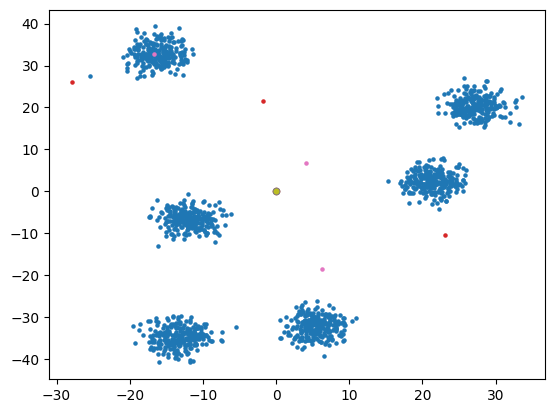

In [35]:
plot_data([0,0], X)
plot_data([0,0], centroids)
plot_data([0,0], new_centroids)
plt.show

In [36]:
for i in range(3): new_centroids = step(new_centroids)

0 587
1 663
2 250
0 742
1 508
2 250
0 750
1 500
2 250


<function matplotlib.pyplot.show(close=None, block=None)>

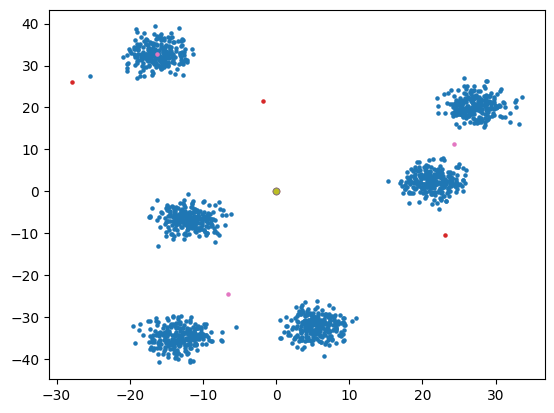

In [37]:
plot_data([0,0], X)
plot_data([0,0], centroids)
plot_data([0,0], new_centroids)
plt.show